In [1]:
import pickle
import copy
import numpy as NP
# from scipy.spatial import KDTree
import scipy as SP
# from scipy import sparse
from astropy import units as U
from astropy import constants as FC
from astropy.io import ascii
# from astroutils import lookup_operations as LKP
# from astroutils import gridding_modules as GRD
import matplotlib as MPL
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from IPython.core.debugger import set_trace

In [2]:
def ix_to_unraveled_ind(ixlist):
    ind_list = [(NP.repeat(ix_[0], ix_[1].size, axis=1).ravel(), NP.repeat(ix_[1], ix_[0].size, axis=0).ravel()) for ix_ in ixlist]
    return ind_list

def unraveled_to_raveled(unraveled_ind_list, shape):
    ind_list = [NP.ravel_multi_index(ind, shape) for ind in unraveled_ind_list]
    return ind_list

def rect2DNN_to_ix_(ycornerNN, xcornerNN, ysizeNN, xsizeNN):
    ycornerNN = NP.array(ycornerNN)
    xcornerNN = NP.array(xcornerNN)
    ysizeNN = NP.array(ysizeNN)
    xsizeNN = NP.array(xsizeNN)
    ix_ = [NP.ix_(ycornerNN[i]+NP.arange(ysizeNN[i]), xcornerNN[i]+NP.arange(xsizeNN[i])) if xsizeNN[i]*ysizeNN[i] > 0 else NP.ix_([], []) for i in range(len(xcornerNN))]
    return ix_

def rect2DNN(x_ngbrof, y_ngbrof, x_ngbrin, y_ngbrin, delX=1, delY=1):
    dx = x_ngbrin[1] - x_ngbrin[0]
    dy = y_ngbrin[1] - y_ngbrin[0]
    delX_fltind = delX / dx
    delY_fltind = delY / dy
    x_ngbrof_fltind = (x_ngbrof - x_ngbrin.min()) / dx
    y_ngbrof_fltind = (y_ngbrof - y_ngbrin.min()) / dy
    delX_rounded = NP.round(delX_fltind).astype(int)
    delY_rounded = NP.round(delY_fltind).astype(int)
    xsizeNN = NP.clip(delX_rounded, 1, None).astype(int)
    ysizeNN = NP.clip(delY_rounded, 1, None).astype(int)
    xcornerNN = NP.round(x_ngbrof_fltind).astype(int) - xsizeNN//2
    ycornerNN = NP.round(y_ngbrof_fltind).astype(int) - ysizeNN//2
    n_oob_xleft = NP.clip(-xcornerNN, 0, None).astype(int)
    n_oob_xright = NP.clip(xcornerNN-(x_ngbrin.size-1), 0, None).astype(int)
    n_oob_yleft = NP.clip(-ycornerNN, 0, None).astype(int)
    n_oob_yright = NP.clip(ycornerNN-(y_ngbrin.size-1), 0, None).astype(int)
    xsizeNN -= (n_oob_xleft + n_oob_xright)
    ysizeNN -= (n_oob_yleft + n_oob_yright)
    areaNN = NP.array(xsizeNN) * NP.array(ysizeNN)
    xcornerNN = NP.clip(xcornerNN, 0, x_ngbrin.size-1).astype(int)
    ycornerNN = NP.clip(ycornerNN, 0, y_ngbrin.size-1).astype(int)
    return (xcornerNN, ycornerNN, xsizeNN, ysizeNN, areaNN)


In [3]:
def grid(rangelist, pad=None, spacing=None, pow2=True, verbose=True):

    """
    -----------------------------------------------------------------------------
    Produce a multi-dimensional grid.
    
    Inputs:
    rangelist [list of tuples] Each tuple is made of two elements, the min and
              max with min < max. One tuple for each axis.
             
    pad       [Optional. Scalar or list] The padding (in same units as range) to
              be applied along the axes. Default=None implies no padding.
              
    spacing   [Optional. Scalar or list] The spacing for the grid along each of
              the axes. If not supplied, a default of sqrt(max-min) is used. If a
              scalar is supplied, it applies for all axes. A list applies for
              each of the axes.
              
    pow2      [Optional, default=True] If set, the grid produced is a power of 2
              in all axes, which is useful for FFT.
              
    verbose   [Default=True]

    Outputs:

    tupleout  [List of tuples] A 4-element tuple for each axis. The elements in
              each tuple are min, max, lengths, and spacing (which could have
              been modified relative to input). The precise grid points can be
              generated by using numpy's linspace using min, max and lengths.
    -----------------------------------------------------------------------------
    """

    for item in rangelist:
        if item[0] >= item[1]:
            raise ValueError('Data ranges provided not compatible with min < max. Exiting from grid().')

    if pad is None:
        pad = NP.zeros(len(rangelist))
    elif isinstance(pad, (int,float)):
        pad = [pad]
    elif isinstance(pad, NP.ndarray):
        pad = pad.tolist()
    elif not isinstance(pad, list):
        raise TypeError('pad must be set to None, scalar, list or numpy array')
        
    if len(pad) == 1:
        pad = [pad] * len(rangelist)
    elif len(pad) > len(rangelist):
        pad = NP.asarray(pad[:len(rangelist)])
    elif (len(pad) > 1) and (len(pad) < len(rangelist)):
        if verbose is True:
            print('Insufficient paddings provided compared to the number of data ranges.')
            print('Assuming the remaining paddings to be zero.')
        pad += [0.0 for ranges in rangelist[len(pad):]]
    # pad = NP.reshape(NP.asarray(pad).reshape(1,-1),len(pad)) # Force it to be row vector
    pad = NP.asarray(pad).flatten()
    pad.clip(min(NP.abs(pad))) # Remove any negative values for pad

    if spacing is None:
        if verbose is True:
            print('No spacing provided. Setting defaults to sqrt(max-min)')
            print('Final spacings could be different from defaults assumed.')
        spacing = [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(rangelist))]
    elif isinstance(spacing, (int, float)):
        if verbose is True:
            print('Scalar value for spacing provided. Assuming spacing is identical along all axes.')
        spacing = [spacing] * len(rangelist)
    elif len(spacing) > len(rangelist):
        if verbose is True:
            print('Too many values of spacing provided. Ignoring values for indices beyond the length of data ranges.')
        spacing = NP.asarray(spacing[:len(rangelist)])
    elif (len(spacing) > 1) and (len(spacing) < len(rangelist)):
        if verbose is True:
            print('Insufficient spacings provided compared to the number of data ranges.')
            print('Assuming the remaining spacings to be default spacing.')
            print('Final spacings could be different from defaults assumed.')
        # spacing += [NP.sqrt(ranges[1]-ranges[0]) for ranges in rangelist[len(spacing):]]
        spacing += [NP.sqrt(rangelist[i][1]-rangelist[i][0]+2*pad[i]) for i in range(len(spacing),len(rangelist))]
    # spacing = NP.asarray(spacing).reshape(1,-1) 
    spacing = NP.asarray(spacing).flatten()
    spacing.clip(min(NP.abs(spacing)))

    rangelist = NP.asarray(rangelist)
    lengths = NP.ceil((rangelist[:,1]-rangelist[:,0]+2*pad)/spacing)+1
    lengths = lengths.astype(int)

    for i in range(len(lengths)): 
        if (lengths[i] % 2) == 0: lengths[i] += 1
        # make it odd number of bin edges enclsoing first
        # and last intervals so that the mid-point is one
        # of the bin edges.

    if pow2 is True:
        lengths = 2**NP.ceil(NP.log2(lengths))
        lengths = lengths.astype(int)
        newspacing = (rangelist[:,1]-rangelist[:,0]+2*pad)/(lengths-2)
        offsets = rangelist[:,0]-pad+(lengths-2)*newspacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets-newspacing, rangelist[:,1]+pad+0.5*offsets, lengths, newspacing)) # converts numpy arrays into a list of tuples
        # tupleout = tuple(map(tuple, NP.column_stack((rangelist[:,0]-pad-0.5*offsets-newspacing, rangelist[:,1]+pad+0.5*offsets, lengths, newspacing)))) # converts numpy arrays into a list of tuples
    else:
        offsets = rangelist[:,0]-pad+(lengths-1)*spacing - (rangelist[:,1]+pad)
        tupleout = list(zip(rangelist[:,0]-pad-0.5*offsets, rangelist[:,1]+pad+0.5*offsets, lengths, spacing)) # converts numpy arrays into a list of tuples
        # tupleout = tuple(map(tuple, NP.column_stack((rangelist[:,0]-pad-0.5*offsets, rangelist[:,1]+pad+0.5*offsets, lengths, spacing)))) # converts numpy arrays into a list of tuples
    
    return tupleout

In [4]:
def array_element_grouping(xcorner, ycorner, nblocks=8):

    nelements, nchan = xcorner.shape
    nelements_per_block = nelements // nblocks
    c = 0

    # Sort by y, then by x coordinate
    sorted_y_indexes = NP.argsort(ycorner[:,c] * 1000 + xcorner[:,c])
    element_by_block = NP.zeros((nblocks, nelements_per_block))
    element_by_block_x = NP.zeros((nblocks, nelements_per_block))
    element_by_block_sorted = []
    for block in range(nblocks):
        for ant in range(nelements_per_block):
            # element number in each of the blocks
            element_by_block[block,ant] = sorted_y_indexes[block*nelements_per_block + ant]
            # x coordinate of the element in each block
            element_by_block_x[block,ant] = xcorner[sorted_y_indexes[block*nelements_per_block + ant],c]
        # sort element_by_block according to element_by_block_x, 
        # so that we have elements in the order they will be used in each block
        x_sort_order = NP.argsort(element_by_block_x[block,:])
        element_by_block_sorted.append(list(element_by_block[block,x_sort_order]))

    # Create an array with dimensions (Ng=nelements_per_block groups)x(Na/g=nblocks elements per group) which contains the element numbers.
    nelements_per_group = nblocks
    nwords_per_frame = nelements // nelements_per_group
    array_grouping = NP.zeros((nwords_per_frame,nelements_per_group), dtype=NP.int32)
    for group in range(nwords_per_frame):
        # Make Ng=nelements_per_block groups, with Na/g=nblocks antennas in each group. 
        # The Na/g antennas have one drawn from each block of nelements_per_block antennas
        array_grouping[group,0] = int(element_by_block_sorted[0][0])
        element_by_block_sorted[0].remove(array_grouping[group,0])
        for block in range(1,nelements_per_group):
            # Make sure the element doesn't have the same y coordinate as the element selected in the previous block
            group_i = 0
            for c in range(nchan):
                while (ycorner[array_grouping[group,block-1],c] == ycorner[int(element_by_block_sorted[block][group_i]),c]):
                    group_i += 1
            array_grouping[group,block] = int(element_by_block_sorted[block][group_i])
            element_by_block_sorted[block].remove(array_grouping[group,block])

    return array_grouping

In [5]:
def gen_ant_grid_wts_cube(vusize, raveled_ind_lol, ant_grid_wts_lol):
    nchan = len(raveled_ind_lol)
    npol = 2
    wtsgrid = NP.zeros((nchan,npol,npol,vusize), dtype=complex) # (nchan,npol,npol,nvusize)
    grid_to_antenna_mapping = NP.zeros((nchan, vusize), dtype=int) # (nchan, nvusize)
    grid_to_antenna_mapping_lol = []
    histgrid = NP.zeros((nchan, vusize), dtype=int) # (nchan, nvusize)
    for iwl in range(nchan):
        grid_to_antenna_mapping_lol[iwl] = []
        for antind, (ravind, awts) in enumerate(zip(raveled_ind_lol[iwl], ant_grid_wts_lol[iwl])):
            # if 
            wts_ixind = NP.ix_([iwl], NP.arange(npol), NP.arange(npol), ravind)
            g2a_ixind = NP.ix_([iwl], ravind)
            wtsgrid[wts_ixind] += awts[NP.newaxis,...] # (1,npol,npol,npix)
            grid_to_antenna_mapping[g2a_ixind] = antind + 1 # (1,npix)
            histgrid[g2a_ixind] += 1
    return (wtsgrid, grid_to_antenna_mapping, histgrid)

def gen_grid_Ef_cube(vusize, raveled_ind_lol, grid_Ef_chan_list):
    nchan = len(raveled_ind_lol)
    nruns = grid_Ef_chan_list[0].shape[0]
    nant = len(raveled_ind_lol[0])
    npol = 2
    outunit = grid_Ef_chan_list[0].unit
    outarr = NP.zeros((nruns,nchan,npol,vusize), dtype=complex) * outunit # (nruns, nchan, npol, nvusize)
    for iwl in range(nchan):
        for ii,ravind in enumerate(raveled_ind_lol[iwl]):
            ixind = NP.ix_(NP.arange(nruns), [iwl], NP.arange(npol), ravind)
            outarr[ixind] += grid_Ef_chan_list[iwl][:,ii,:,:][:,NP.newaxis,...] # (nruns,1,npol,npix)
    return outarr

def gen_image(inparr, fftshape=None, fftaxes=(-2,-1), polaxis=-4, freqaxis=-3, bwsyn=False):
    polaxis = (polaxis+inparr.ndim) % inparr.ndim
    freqaxis = (freqaxis+inparr.ndim) % inparr.ndim
    outarr = SP.fft.fft2(inparr, s=fftshape, axes=fftaxes)
    outarr = NP.expand_dims(outarr, axis=polaxis) * NP.expand_dims(outarr, axis=polaxis+1).conj()
    if bwsyn:
        outarr = NP.sum(outarr, axis=freqaxis, keepdims=True)
    outarr = SP.fft.fftshift(outarr, axes=fftaxes)
    return outarr

In [6]:
fc = 100*U.MHz
df = 100 * U.kHz
nchan = 10
duration = 100*U.ms
bw = nchan * df
freqs = fc + df * (NP.arange(nchan) - nchan//2)
wl = (FC.c / freqs).to(U.m)
delT = (1/df).to(U.s)
dt = (1/bw).to(U.s)
nruns = NP.round((duration/delT).decompose()).astype(int)
npol = 2
times = NP.arange(nruns) * delT

In [7]:
datadir = '/mnt/data/users/thy009/projects/multi-scale-imaging-architectures/data/'
antwtsfile = 'epic-test-ant-wts-64x64-grid-256-ants-10-chans.pkl'
bindatafile = 'epic-test-data-10000-runs-64x64-grid-256-ants-10-chans.bin'
# aavs_antlocs_file = 'AAVS2_loc_italia_190429.txt'
aavs_antlocs_file = 'AAVS2_loc_italia_190429_modified.txt'
element_grouping_file = 'array_element_ordering_FPGA-64x64-grid-256-ants-10-chans.npy'
# element_grouping_file = 'aavs_station_element_fpga_ordering_32x8.npy'

## Read antenna locations

In [8]:
anttab = ascii.read(datadir+aavs_antlocs_file, names=['id', 'x', 'y', 'z'], format='no_header')
anttab['id'] = anttab['id'].astype(int)
anttab['x'] = anttab['x'] * U.m
anttab['y'] = anttab['y'] * U.m
anttab['z'] = anttab['z'] * U.m
nants = anttab['id'].size
antx = anttab['x']
anty = anttab['y']
antz = anttab['z']
antx = antx - NP.mean(antx) * anttab['x'].unit
anty = anty - NP.mean(anty) * anttab['y'].unit
antz = antz - NP.mean(antz) * anttab['z'].unit

In [9]:
anttab.pprint()

 id   x      y    z  
      m      m    m  
--- ------ ----- ----
  1  17.47 -6.81 15.0
  2   17.7 -3.94 16.0
  3  18.89 -1.21 16.0
  4  18.11  1.02 16.0
  5  17.92  3.28 16.0
  6  15.75  8.85  5.0
  7  15.85  6.68  5.0
  8  16.94  5.18  5.0
  9  15.17 -0.69 16.0
 10  16.19 -1.99 16.0
...    ...   ...  ...
247 -16.08  4.29  9.0
248 -17.09  5.57  9.0
249  -15.4  6.96  9.0
250 -16.04 10.18  9.0
251 -17.32  7.53  9.0
252 -18.67  3.36  9.0
253 -18.51  1.41 10.0
254 -18.26 -0.33 10.0
255 -17.35 -3.38 10.0
256  -17.6 -6.37 11.0
Length = 256 rows


In [10]:
anttab.show_in_notebook(display_length=300)

idx,id,x,y,z
,,m,m,m
0,1,17.47,-6.81,15.0
1,2,17.7,-3.94,16.0
2,3,18.89,-1.21,16.0
3,4,18.11,1.02,16.0
4,5,17.92,3.28,16.0
5,6,15.75,8.85,5.0
6,7,15.85,6.68,5.0
7,8,16.94,5.18,5.0
8,9,15.17,-0.69,16.0


In [11]:
au = antx.reshape(-1,1) / wl.reshape(1,-1)
av = anty.reshape(-1,1) / wl.reshape(1,-1)
aw = antz.reshape(-1,1) / wl.reshape(1,-1)
au_min = au.min()
av_min = av.min()
aw_min = aw.min()
au_max = au.max()
av_max = av.max()
aw_max = aw.max()
print(au_min, av_min, aw_min)
print(au_max, av_max, aw_max)

-6.138058850032846 -6.307404911016809 -2.511737636842085
6.440723235272317 6.308215992962038 2.511737636842085


In [12]:
print(anttab['z'].min(), anttab['z'].max())
print(NP.mean(anttab['x']))
print(NP.mean(anttab['y']))
print(NP.mean(anttab['z']))
print(antx.shape)

1.0 16.0
-0.34187499999999993
-0.08621093750000006
8.5
(256,)


In [13]:
sizex_ant = 1.64 * U.m
sizey_ant = 1.64 * U.m 
ant_sampling_factor = 2.0
upad = sizex_ant / wl.min()
vpad = sizey_ant / wl.min()
du_ant = sizex_ant / (ant_sampling_factor * wl.max())
dv_ant = sizey_ant / (ant_sampling_factor * wl.max())
ant_uvec_info, ant_vvec_info = grid([(au_min,au_max), (av_min,av_max)], pad=[upad, vpad], spacing=[du_ant, dv_ant], pow2=True)
ant_uvec = NP.linspace(ant_uvec_info[0], ant_uvec_info[1], num=ant_uvec_info[2], endpoint=True)
ant_vvec = NP.linspace(ant_vvec_info[0], ant_vvec_info[1], num=ant_vvec_info[2], endpoint=True)
ant_ugrid, ant_vgrid = NP.meshgrid(ant_uvec, ant_vvec)
print(ant_ugrid.shape)

(64, 64)


## Plot the antenna locations with z-displacement shown in color

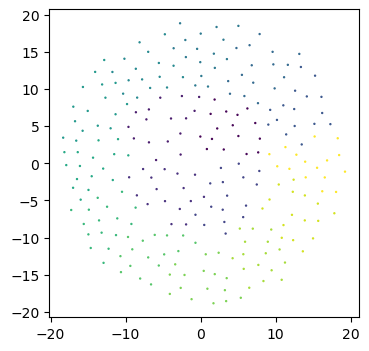

In [14]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.scatter(antx.si, anty.si, s=2, c=antz.si.value, marker='.', cmap='viridis')

## Load the antenna weights with channel and grid position information

In [15]:
with open(datadir+'epic-test-ant-wts-{0:0d}x{1:0d}-grid-{2:0d}-ants-{3:0d}-chans.pkl'.format(ant_ugrid.shape[0], ant_ugrid.shape[1], nants, nchan), 'rb') as fobj:
    ant_grid_wts_lol = pickle.load(fobj)

## Do some reorganisation of the grid indices

In [16]:
ix_list = []
unraveled_ind_lol = []
raveled_ind_lol = []
delX = (NP.zeros((nants,1))+sizex_ant/wl.reshape(1,-1)).ravel()
delY = (NP.zeros((nants,1))+sizey_ant/wl.reshape(1,-1)).ravel()
xcornerNN, ycornerNN, xsizeNN, ysizeNN, areaNN = rect2DNN(au.ravel(), av.ravel(), ant_uvec, ant_vvec, delX=delX, delY=delY)
xcornerNN = xcornerNN.reshape(nants, -1)
ycornerNN = ycornerNN.reshape(nants, -1)
xsizeNN = xsizeNN.reshape(nants, -1)
ysizeNN = ysizeNN.reshape(nants, -1)
areaNN = areaNN.reshape(nants, -1)
for iwl in range(wl.size):    
    ix_ = rect2DNN_to_ix_(ycornerNN[:,iwl], xcornerNN[:,iwl], ysizeNN[:,iwl], xsizeNN[:,iwl])
    ix_list += [copy.deepcopy(ix_)]
    unraveled_ind = ix_to_unraveled_ind(ix_)
    unraveled_ind_lol += [copy.deepcopy(unraveled_ind)]
    raveled_ind = unraveled_to_raveled(unraveled_ind, ant_ugrid.shape)
    raveled_ind_lol += [copy.deepcopy(raveled_ind)]

## Read element grouping file

In [17]:
element_grouping = NP.load(datadir+element_grouping_file)
print(element_grouping.ravel())
print(NP.argsort(element_grouping.ravel()))

[235 237 255 253 252 250 249 223 209 236 239 254 251 247 224 192 210 234
 238 241 245 246 225 222 208 233 232 243 244 248 226 193 178 211 231 240
 229 227 221 191 179 212 214 242 228 219 195 190 177 206 213 230 217 220
 194 163 174 207 215 216 218 199 197 162 173 205 204 202 201 198 196 159
 176 180 203 184 200 186 189 157 175 181 182 183 185 187 188 161 143 172
 171 170 168 153 164 160 141 147 148 169 167 152 166 158 142 144 137 150
 151 154 165 129 140 146 138 149 135 134 155 130 112 145 117 136 119 122
 156 126 113 139 116 118 120 121 132 128 110 115 102  99  98  96 131 127
 111 114 103 100  83  97 133 125 109 104 101  80  81  84 124  92 107  77
  79  65  82  85 123  93 108  75  78  64  63  60  95  89 106  76  66  48
  62  61  94  91  74  67  46  47  49  51  86  87 105  69  45  34  32  50
  58  88  72  68  36  35  33  52  53  90  73  44  37  17  20  31  59  57
  70  42  15   8  18  30  54  56  71  43  16   9  21  29  28  55  41  38
  12  10  19  22  23  27  40  13  11   1   4   6  2

## Read binary data file prepared for FPGA consumption and restructure the data to human readable numpy format

In [18]:
datafpga = NP.fromfile(datadir+bindatafile, dtype=NP.int8)
datafpga = datafpga.reshape(nchan, nruns, nants, npol, -1)
datafpga = datafpga[...,0] + 1j * datafpga[...,1]
ant_Eftap = NP.take(datafpga, NP.argsort(element_grouping.ravel()), axis=-2) * U.Jy**(1/2)
ant_Etafp = NP.moveaxis(ant_Eftap, 0, -2)

## Organise the gridded E-field data into channels

In [19]:
grid_Ef_list = []
for iwl in range(wl.size):    
    ant_grid_wts_chan = NP.array(ant_grid_wts_lol[iwl]) # (nant,npol,npol,npix)
    grid_Ef = NP.einsum('ijkl,hik->hijl', NP.array(ant_grid_wts_chan), ant_Etafp[...,iwl,:]) # (nant,npol,npol,npix).(nruns,nant,npol) --> (nruns,nant,npol,npix)
    grid_Ef_list += [NP.copy(grid_Ef)]

## Synthesise gridded weights and gridded E-fields dynamic spectra

In [20]:
grid_wts_cube, grid_to_antenna_mapping, gridhist = gen_ant_grid_wts_cube(ant_ugrid.size, raveled_ind_lol, ant_grid_wts_lol)
grid_E_dynspec = gen_grid_Ef_cube(ant_ugrid.size, raveled_ind_lol, grid_Ef_list)

In [21]:
grid_wts_cube = grid_wts_cube.reshape((grid_wts_cube.shape[:-1]+ant_ugrid.shape))
grid_E_dynspec = grid_E_dynspec.reshape((grid_E_dynspec.shape[:-1]+ant_ugrid.shape))
grid_to_antenna_mapping = grid_to_antenna_mapping.reshape((grid_to_antenna_mapping.shape[:-1]+ant_ugrid.shape))
gridhist = gridhist.reshape((gridhist.shape[:-1]+ant_ugrid.shape))

In [22]:
print(grid_E_dynspec.shape) # (nruns,nchan,npol,nimy,nimx)
print(grid_wts_cube.shape)
print(grid_to_antenna_mapping.shape)
print(gridhist.shape)

(10000, 10, 2, 64, 64)
(10, 2, 2, 64, 64)
(10, 64, 64)
(10, 64, 64)


## output image shape to be twice on each side of the antenna grid (optional padding but useful to avoid aliasing)

In [23]:
pad_factor = 1
imshape = (pad_factor*ant_ugrid.shape[0], pad_factor*ant_ugrid.shape[1])
print(imshape) # (nimy,nimx)

(64, 64)


## Generate dynamic spectrum image (including auto-correlations)

In [24]:
img_cube_AC = gen_image(grid_E_dynspec, fftshape=imshape, fftaxes=(-2,-1), polaxis=-3, freqaxis=-4, bwsyn=False)

## Perform synthesis (averaging) along time axis

In [25]:
tsyn_img_cube_AC = NP.mean(img_cube_AC, axis=(0,1), keepdims=True)
t10_img_cube_AC = NP.mean(img_cube_AC[:10,...], axis=(0,1), keepdims=True)

In [26]:
print(img_cube_AC.shape) # (nruns,nchan,npol,npol,nimy,nimx)
print(tsyn_img_cube_AC.shape) # (1,1,npol,npol,nimy,nimx)
print(tsyn_img_cube_AC.shape) # (1,1,npol,npol,nimy,nimx)

(10000, 10, 2, 2, 64, 64)
(1, 1, 2, 2, 64, 64)
(1, 1, 2, 2, 64, 64)


## Plot grid weights visualised by layers of frequency channels

Text(0.5, 0, '$\\nu$ [MHz]')

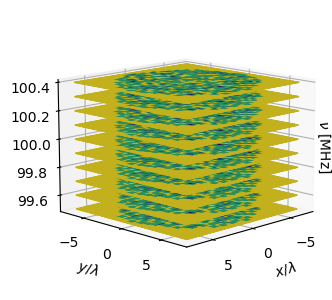

In [69]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for chan in range(nchan):
    colors = grid_wts_cube[chan,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    # m.set_array([])
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, freqs[chan]+NP.zeros(ant_ugrid.shape), cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=12.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$x/\lambda$')
ax.set_ylabel(r'$y/\lambda$')
ax.set_zlabel(r'$\nu$ [MHz]', labelpad=-130, rotation=180)

## Visualise image dynamic spectra along layers of frequency channels (including auto-correlations)

Text(0.5, 0, '$\\nu$ [MHz]')

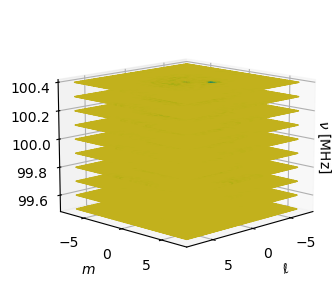

In [70]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for chan in range(nchan):
    colors = img_cube_AC[0,chan,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, freqs[chan]+NP.zeros(ant_ugrid.shape)*U.Hz, cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=12.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$m$')
ax.set_zlabel(r'$\nu$ [MHz]', labelpad=-130, rotation=180)

## Visualise time-averaged image of a single channel (includes auto-correlations)

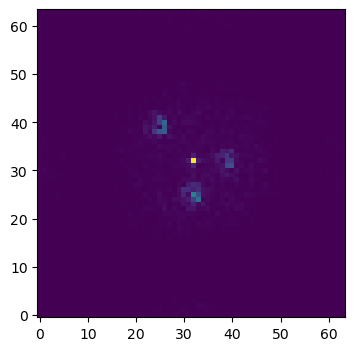

In [71]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(tsyn_img_cube_AC[0,0,0,0,:,:].real, origin='lower', interpolation='none')

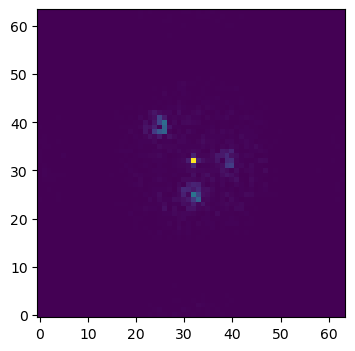

In [27]:
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(t10_img_cube_AC[0,0,0,0,:,:].real, origin='lower', interpolation='none')

## Visualise image time frames (including auto-correlations)

Text(0.5, 0, '$t$ [ms]')

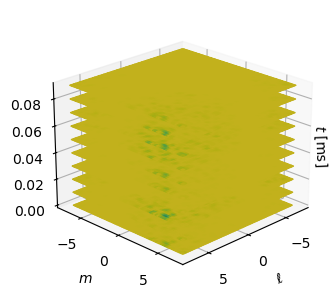

In [64]:
tind = NP.arange(10)
ichan = 0
fig = PLT.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
for ti in tind:
    colors = img_cube_AC[ti,0,0,0,:,:].real
    cmin = colors.min()
    cmax = colors.max()
    norm = MPL.colors.Normalize(vmin=cmin, vmax=cmax)
    m = PLT.cm.ScalarMappable(cmap='viridis_r')
    fcolors = m.to_rgba(colors)
    ax.plot_surface(ant_ugrid, ant_vgrid, times[ti].to('ms')*NP.ones(ant_ugrid.shape), cstride=1, rstride=1, facecolors=fcolors, vmin=colors.min(), vmax=colors.max())
ax.view_init(elev=22.5, azim=45, roll=0)
fig.subplots_adjust(left=0.25, right=0.95, bottom=0.1, top=0.95)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$m$')
ax.set_zlabel(r'$t$ [ms]', labelpad=-130, rotation=180)